In [21]:
import io
import os
import cv2
import json
import yaml
import torch
import shutil
import subprocess
import collections
import pkg_resources
import collections.abc

import time
import torch
import pickle
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path
from collections import OrderedDict
from torch.utils.data.dataloader import DataLoader

from data import PA_100K, Peta
from database import *
from models import *
from utils import *

In [22]:
datasource = PA_100K(root_dir='/datasets', download=True, extract=True)
attribute_name = datasource.get_attribute()
attribute_label = attribute_name

Copying data...
Downloading...
Downloaded!


In [23]:
list_attribute_rand = np.array(datasource.get_list_attribute_random())
list_attribute_rand[list_attribute_rand == 1] = 2
print(len(list_attribute_rand))

1769472


Query xong xoá db

In [73]:
# list_num_sample = [100, 1000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000, 2000000]
list_num_sample = [10000*x*2 for x in range(1, 100)]
list_num_sample

[20000,
 40000,
 60000,
 80000,
 100000,
 120000,
 140000,
 160000,
 180000,
 200000,
 220000,
 240000,
 260000,
 280000,
 300000,
 320000,
 340000,
 360000,
 380000,
 400000,
 420000,
 440000,
 460000,
 480000,
 500000,
 520000,
 540000,
 560000,
 580000,
 600000,
 620000,
 640000,
 660000,
 680000,
 700000,
 720000,
 740000,
 760000,
 780000,
 800000,
 820000,
 840000,
 860000,
 880000,
 900000,
 920000,
 940000,
 960000,
 980000,
 1000000,
 1020000,
 1040000,
 1060000,
 1080000,
 1100000,
 1120000,
 1140000,
 1160000,
 1180000,
 1200000,
 1220000,
 1240000,
 1260000,
 1280000,
 1300000,
 1320000,
 1340000,
 1360000,
 1380000,
 1400000,
 1420000,
 1440000,
 1460000,
 1480000,
 1500000,
 1520000,
 1540000,
 1560000,
 1580000,
 1600000,
 1620000,
 1640000,
 1660000,
 1680000,
 1700000,
 1720000,
 1740000,
 1760000,
 1780000,
 1800000,
 1820000,
 1840000,
 1860000,
 1880000,
 1900000,
 1920000,
 1940000,
 1960000,
 1980000]

In [7]:
print('Connecting to db {}'.format(9))
database = Database_reid(host='127.0.0.1', port=6379, db=9)
print(database.is_redis_available())
print('Connected to db {}'.format(9))

database.remove_all()
print('remove all data from database: ', 9)

Connecting to db 9
True
Connected to db 9
remove all data from database:  9


In [75]:
database.set_attribute_label(attribute_name)
query_dict = {'Female': False, 'Age18-60': True, 'Backpack': True, 'Shorts': False}
query_str = database.get_query_key(query_dict, with_one=True)

In [76]:
list_time_insert = []
list_time_avg_query = []
list_time_query_all = []

num_images = 50
for idx in range(len(list_num_sample)):
    num_sample = list_num_sample[idx]
    print('num sample: ', num_sample)
    database.r.flushdb()
    all_data = list(zip(['a.jpg']*num_sample, list_attribute_rand[np.random.choice(list_attribute_rand.shape[0], num_sample, replace=True), :].tolist()))
    
    list_time_insert.append(database.insert(data=all_data, attribute_label=attribute_label))
    
    start_time = time.time()
    all_time = 0
    num_query = 0
    for index, all_keys in enumerate(database.query_fixed_count(query_str, num_images=num_images)):
        all_time += time.time()-start_time
        start_time = time.time()
        num_query += 1
    if num_query == 0:
        num_query = 1
    list_time_avg_query.append(all_time/num_query)

    start_time = time.time()
    all_path = database.query_all(query_str)
    list_time_query_all.append(time.time()-start_time)

with open("time_insert.pkl", "wb") as f:
    pickle.dump({
        'list_sample': list_num_sample, 
        'list_time_insert': list_time_insert,
        'list_time_avg_query': list_time_avg_query,
        'list_time_query_all': list_time_query_all
    }, f)

num sample:  20000
num sample:  40000
num sample:  60000
num sample:  80000
num sample:  100000
num sample:  120000
num sample:  140000
num sample:  160000
num sample:  180000
num sample:  200000
num sample:  220000
num sample:  240000
num sample:  260000
num sample:  280000
num sample:  300000
num sample:  320000
num sample:  340000
num sample:  360000
num sample:  380000
num sample:  400000
num sample:  420000
num sample:  440000
num sample:  460000
num sample:  480000
num sample:  500000
num sample:  520000
num sample:  540000
num sample:  560000
num sample:  580000
num sample:  600000
num sample:  620000
num sample:  640000
num sample:  660000
num sample:  680000
num sample:  700000
num sample:  720000
num sample:  740000
num sample:  760000
num sample:  780000
num sample:  800000
num sample:  820000
num sample:  840000
num sample:  860000
num sample:  880000
num sample:  900000
num sample:  920000
num sample:  940000
num sample:  960000
num sample:  980000
num sample:  1000000
num

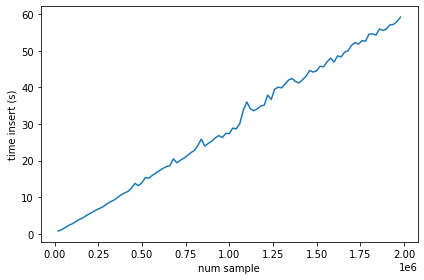

In [8]:
with open("time_insert.pkl", "rb") as f:
    dict_obj = pickle.load(f)
    
list_num_sampler = dict_obj['list_sample']
list_time_insert = dict_obj['list_time_insert']
list_time_avg_query = dict_obj['list_time_avg_query']
list_time_query_all = dict_obj['list_time_query_all']

plt.xlabel('num sample')
plt.ylabel('time insert (s)')
plt.plot(list_num_sampler, list_time_insert, label='time insert')
plt.tick_params(axis='y')
plt.tight_layout()
plt.show()

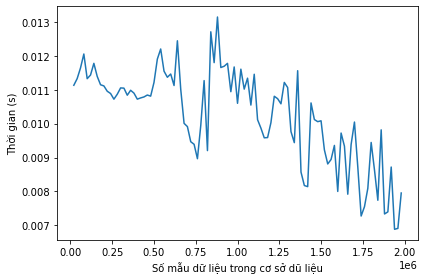

In [2]:
 import pickle
 import matplotlib.pyplot as plt

 with open("time_insert.pkl", "rb") as f:
    dict_obj = pickle.load(f)
    
list_num_sampler = dict_obj['list_sample']
list_time_insert = dict_obj['list_time_insert']
list_time_avg_query = dict_obj['list_time_avg_query']
list_time_query_all = dict_obj['list_time_query_all']

plt.xlabel('Số mẫu dữ liệu trong cơ sở dữ liệu')
plt.ylabel('Thời gian (s)')
plt.plot(list_num_sampler, list_time_avg_query, label='Thời gian truy xuất')
plt.tick_params(axis='y')
plt.tight_layout()
# plt.show()
plt.savefig('list_time_avg_query.pdf')

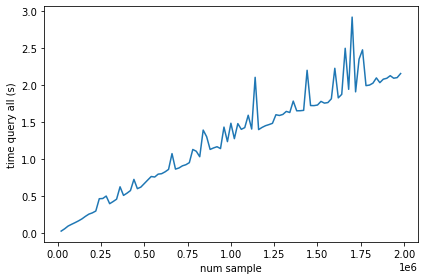

In [10]:
 with open("time_insert.pkl", "rb") as f:
    dict_obj = pickle.load(f)

list_num_sampler = dict_obj['list_sample']
list_time_insert = dict_obj['list_time_insert']
list_time_avg_query = dict_obj['list_time_avg_query']
list_time_query_all = dict_obj['list_time_query_all']

plt.xlabel('num sample')
plt.ylabel('time query all (s)')
plt.plot(list_num_sampler, list_time_query_all, label='time query all')
plt.tick_params(axis='y')
plt.tight_layout()
plt.show()

Query khi db có sãn

In [24]:
print('Connecting to db {}'.format(9))
database = Database_reid(host='127.0.0.1', port=6379, db=9)
print(database.is_redis_available())
print('Connected to db {}'.format(9))

database.remove_all()
print('remove all data from database: ', 9)

Connecting to db 9
True
Connected to db 9
remove all data from database:  9


In [39]:
list_num_sample = [x*20000 for x in range(100)]
list_num_sample

[0,
 20000,
 40000,
 60000,
 80000,
 100000,
 120000,
 140000,
 160000,
 180000,
 200000,
 220000,
 240000,
 260000,
 280000,
 300000,
 320000,
 340000,
 360000,
 380000,
 400000,
 420000,
 440000,
 460000,
 480000,
 500000,
 520000,
 540000,
 560000,
 580000,
 600000,
 620000,
 640000,
 660000,
 680000,
 700000,
 720000,
 740000,
 760000,
 780000,
 800000,
 820000,
 840000,
 860000,
 880000,
 900000,
 920000,
 940000,
 960000,
 980000,
 1000000,
 1020000,
 1040000,
 1060000,
 1080000,
 1100000,
 1120000,
 1140000,
 1160000,
 1180000,
 1200000,
 1220000,
 1240000,
 1260000,
 1280000,
 1300000,
 1320000,
 1340000,
 1360000,
 1380000,
 1400000,
 1420000,
 1440000,
 1460000,
 1480000,
 1500000,
 1520000,
 1540000,
 1560000,
 1580000,
 1600000,
 1620000,
 1640000,
 1660000,
 1680000,
 1700000,
 1720000,
 1740000,
 1760000,
 1780000,
 1800000,
 1820000,
 1840000,
 1860000,
 1880000,
 1900000,
 1920000,
 1940000,
 1960000,
 1980000]

In [34]:
list_time_insert_2 = []
num_sample_per_once = 20000

database.remove_all()
for idx in range(100):
    print(idx)
    all_data = list(zip(['a.jpg']*num_sample_per_once, list_attribute_rand[np.random.choice(list_attribute_rand.shape[0], num_sample_per_once, replace=True), :].tolist()))
    
    list_time_insert_2.append(database.insert(data=all_data, attribute_label=attribute_label))
    
with open("time_insert_2.pkl", "wb") as f:
    pickle.dump({
        'list_num_sample': list_num_sample, 
        'list_time_insert_2': list_time_insert_2,
    }, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


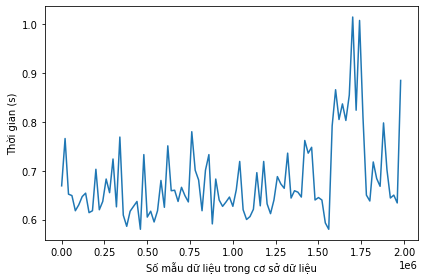

In [4]:
 import pickle
 import matplotlib.pyplot as plt

 with open("time_insert_2.pkl", "rb") as f:
    dict_obj = pickle.load(f)

list_num_sample = dict_obj['list_sample']
# print(len(list_num_sample))
list_time_insert_2 = dict_obj['list_time_insert_2']
# print(len(list_time_insert_2))

plt.xlabel('Số mẫu dữ liệu trong cơ sở dữ liệu')
plt.ylabel('Thời gian (s)')
plt.plot(list_num_sample, list_time_insert_2, label='Thời gian insert')
plt.tick_params(axis='y')
plt.tight_layout()
# plt.show()
plt.savefig('list_time_insert_2.pdf')